# Frameworks

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import signal

# Leitura dos Dados Brutos

In [3]:
path_date = './DADOS/Dados eficiência da Usina Petrolina.xlsx'
df_full = pd.read_excel(path_date, usecols=['Time', 'Potência AC total (kW)', 'POA (W/m²)'])

In [4]:
df_full.head()

,Time,Potência AC total (kW),POA (W/m²)
0,2019-01-01 05:56:00,0.0,21.43
1,2019-01-01 05:57:00,0.0,23.98
2,2019-01-01 05:58:00,0.0,26.67
3,2019-01-01 05:59:00,0.0,30.27
4,2019-01-01 06:00:00,0.0,34.88


In [5]:
df_full.rename(columns={'Potência AC total (kW)':'P', 'POA (W/m²)':'G'}, inplace=True)

In [6]:
df_full.head()

,Time,P,G
0,2019-01-01 05:56:00,0.0,21.43
1,2019-01-01 05:57:00,0.0,23.98
2,2019-01-01 05:58:00,0.0,26.67
3,2019-01-01 05:59:00,0.0,30.27
4,2019-01-01 06:00:00,0.0,34.88


# Transformando o `DataFrame` em Série Teporal

In [7]:
df = df_full.copy()
df = df.set_index('Time')
df = df.sort_index(ascending=True)
df.head()

,P,G
Time,,
2019-01-01 05:56:00,0.0,21.43
2019-01-01 05:57:00,0.0,23.98
2019-01-01 05:58:00,0.0,26.67
2019-01-01 05:59:00,0.0,30.27
2019-01-01 06:00:00,0.0,34.88


# Verificando se há 525.600 Amostras _(Qtd. de Minutos em Um Ano)_

In [8]:
texto1 = 'Amostras Em Um Ano: ..................'
tamnaho_do_df = len(df.index)
print(f'{texto1} {tamnaho_do_df}')

texto2 = 'Qtd. de Minutos em Um Ano: ...........'
minutos_em_um_ano = 365 * 24 * 60
print(f'{texto2}', minutos_em_um_ano)

texto3 = 'Percentual de Minutos Não coletadas: .'
percentual = ((minutos_em_um_ano - len(df.index))/minutos_em_um_ano)*100
print(f'{texto3} {percentual:.2f} {'%'}')

texto4 = 'Qtd. de Dados Não Coletados:..........'
print(f'{texto4}', minutos_em_um_ano - len(df.index))

Amostras Em Um Ano: .................. 244154
Qtd. de Minutos em Um Ano: ........... 525600
Percentual de Minutos Não coletadas: . 53.55 %
Qtd. de Dados Não Coletados:.......... 281446


# Identificando e Quantificando os "Buracos" nos Dados do Sensor

In [9]:
# Calcula a diferença de tempo entre uma linha e a anterior
time_diffs = df.index.to_series().diff()
# Filtra onde a diferença é maior que 1 minuto
gaps = time_diffs[time_diffs > pd.Timedelta('1min')]
print(f"Total de 'gaps' na amostragem: ... {len(gaps)}")
gaps.head()

Total de 'gaps' na amostragem: ... 491


Time
2019-01-02 05:48:00   0 days 12:17:00
2019-01-02 17:26:00   0 days 00:03:00
2019-01-03 05:54:00   0 days 12:27:00
2019-01-03 17:19:00   0 days 00:04:00
2019-01-04 05:56:00   0 days 12:36:00
Name: Time, dtype: timedelta64[ns]

# Verificando se há _NaN_

* A tecnica `df.isna().sum()` retornou **False** para todos,
isso implica que há saltos temporais no registro da base.
Alguém poderia achar que o sensor fez o registro do tempo na coluna **Time**,
mas o valor da coluna da irradiancia e da potencia ficou com _NaN_
O teste mostra que não é o caso.

In [10]:
df.isna().sum()

P    0
G    0
dtype: int64

# SubPlot Com Gráfico de dispersão Para verificar como os registros de Potência e Irradiância ocorrem ao longo de _24h_

A análise do gráfico confirma tudo que já vinhamos notando:

* Dados NÃO **EXISTENTES** para periodos Noturnos (Antes das 5h e depois das 18h);
* Ideitifica-se valores **ZERADOS** para potência em horário de sol pleno. 

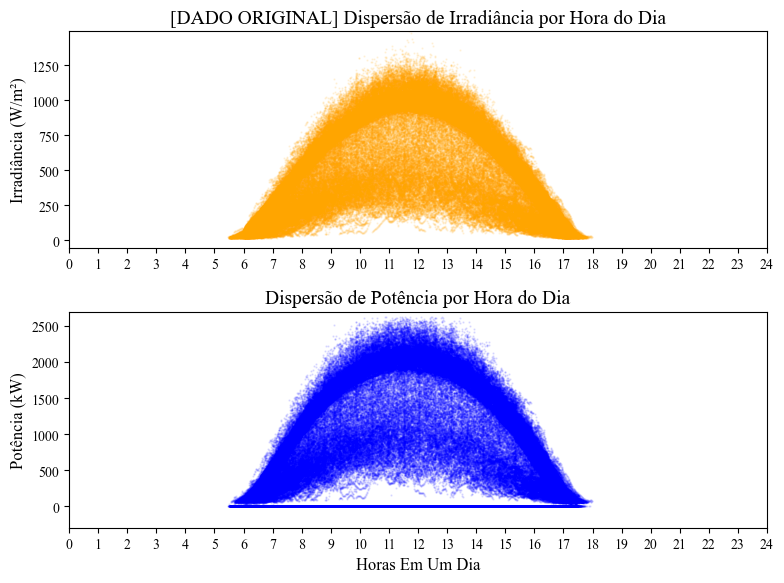

In [11]:
plt.rcParams.update({
    'font.family': 'serif',          # Define que a família será serifada
    'font.serif': ['Times New Roman'], # Especifica Times New Roman
    'font.size': 12,                 # Tamanho base
    'axes.labelsize': 12,            # Tamanho dos eixos
    'axes.titlesize': 14,            # Tamanho do título
    'xtick.labelsize': 10,           # Tamanho dos números em X
    'ytick.labelsize': 10,           # Tamanho dos números em Y
    'legend.fontsize': 10,           # Tamanho da legenda
    'figure.figsize': (8, 6),        # Tamanho da figura
    'mathtext.fontset': 'stix'       # Deixa as fórmulas matemáticas bonitas (estilo LaTeX)
})
# Criar coluna de hora decimal para o eixo X (ex: 14:30 = 14.5)
df['HoraDecimal'] = df.index.hour + df.index.minute / 60
# Plot da Irradiância
plt.subplot(2, 1, 1)
plt.scatter(df['HoraDecimal'], df['G'], s=0.5, alpha=0.1, color='orange')
plt.title('[DADO ORIGINAL] Dispersão de Irradiância por Hora do Dia')
plt.ylabel('Irradiância (W/m²)')
plt.xlim(0, 24)
plt.ylim(-50, 1492.9)
#plt.grid(True, alpha=0.1)
plt.xticks(list(range(0, 25)))
# Plot da Potência
plt.subplot(2, 1, 2)
plt.scatter(df['HoraDecimal'], df['P'], s=0.5, alpha=0.1, color='blue')
plt.title('Dispersão de Potência por Hora do Dia')
plt.xlabel('Horas Em Um Dia')
plt.ylabel('Potência (kW)')
plt.xlim(0, 24)
plt.ylim(-300, 2700) 
#plt.grid(True, alpha=0.1)
plt.xticks(list(range(0, 25)))
plt.tight_layout()
plt.savefig('./GRAFICOS/DADO_ORIGINAL_dispersão_da_irradiância_e_potencia_por_hora_do_dia.png', format='png', dpi=600, bbox_inches='tight')

# Ações De Correção Para Os Dados Ausentes: **Uma Primeira Aprioximação**

#### **A Lógica da Máscara Diurna/Noturna Reconstruir o Tempo:**


1) Criar a linha do tempo completa (com os `NaN` onde falta dado);

2) Definir a **"Zona da Noite"**: Estabeleci que entre **19:00 e 05:00** é impossível ter sol `significativo`.

3) **Tratamento Condicional:**

* Se o dado falta na Zona da Noite $\rightarrow$ Preenchi com **ZERO**;
* Se o dado falta na Zona do Dia $\rightarrow$ Apliquei **INTERPOLAÇÃO** (não importa se o buraco é de 10 min ou 4 horas, o sol estava lá, então liguei os pontos).

In [12]:
# RECONSTRUÇÃO DA LINHA DO TEMPO
start = df.index.min().floor('D')
end = df.index.max().ceil('D')
full_index = pd.date_range(start, end, freq='1min', inclusive='left')
# Reindexa: Cria as linhas que faltavam (buracos) e preenche com NaN
df_new = df.reindex(full_index)
# MÁSCARA
hours = df_new.index.hour
mask_night = (hours < 5) | (hours >= 19)
# APLICAÇÃO DAS REGRAS DE LIMPEZA
df_new.loc[mask_night & df_new['G'].isna(), 'G'] = 0
df_new.loc[mask_night & df_new['P'].isna(), 'P'] = 0
# REGRA 2: Buracos no DIA são INTERPOLADOS
# Como os buracos da noite já viraram 0.0, a interpolação só agirá nos buracos diurnos restantes
df_new['G'] = df_new['G'].interpolate(method='time', limit_direction='both')
df_new['P'] = df_new['P'].interpolate(method='time', limit_direction='both')
# VALIDAÇÃO FINAL
print("=== Relatório de Integridade ===")
print(f"Tamanho esperado (linhas): {len(full_index)}")
print(f"Tamanho real (linhas):     {len(df_new)}")
print("-" * 30)
# Correção: Ajustado para verificar a coluna certa em cada print
print(f"Total de NaNs restantes em P: {df_new['P'].isna().sum()}")
print(f"Total de NaNs restantes em G: {df_new['G'].isna().sum()}")

=== Relatório de Integridade ===
Tamanho esperado (linhas): 525600
Tamanho real (linhas):     525600
------------------------------
Total de NaNs restantes em P: 0
Total de NaNs restantes em G: 0


# Refazendo o Gráfico de Dispersão Com o Novo Conjunto de Dados

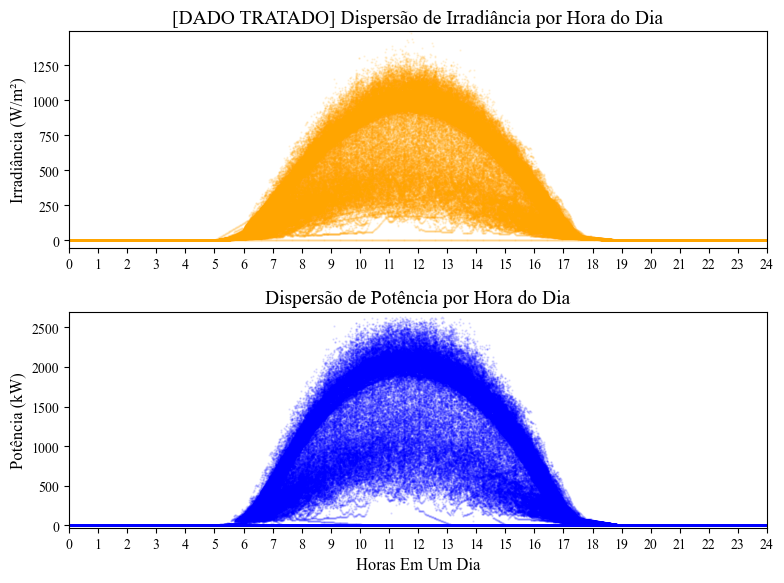

In [13]:
# Criar coluna de hora decimal para o eixo X (ex: 14:30 = 14.5)
df_new['HoraDecimal'] = df_new.index.hour + df_new.index.minute / 60
# Plot da Irradiância
plt.subplot(2, 1, 1)
plt.scatter(df_new['HoraDecimal'], df_new['G'], s=0.5, alpha=0.1, color='orange')
plt.title('[DADO TRATADO] Dispersão de Irradiância por Hora do Dia')
plt.ylabel('Irradiância (W/m²)')
plt.xlim(0, 24)
plt.ylim(-50, 1492.9)
#plt.grid(True, alpha=0.1)
plt.xticks(list(range(0, 25)))
# Plot da Potência
plt.subplot(2, 1, 2)
plt.scatter(df_new['HoraDecimal'], df_new['P'], s=0.5, alpha=0.1, color='blue')
plt.title('Dispersão de Potência por Hora do Dia')
plt.xlabel('Horas Em Um Dia')
plt.ylabel('Potência (kW)')
plt.xlim(0, 24)
plt.ylim(-30, 2700) 
plt.xticks(list(range(0, 25)))
plt.tight_layout()
plt.savefig('./GRAFICOS/DADO_TRATADO_dispersão_da_irradiância_e_potencia_por_hora_do_dia.png', format='png', dpi=600, bbox_inches='tight')

# Uma Análise Mais Profunda dos _`Gaps`_ Focada nos Dados Faltantes e Inconsistentes **No Período Diurno**

* Dados, mesmo que ausentes, se no período noturno, **são zeros por definição**.
A maior preocupação são os dados inconsistentes e ausentes nos períodos de sol, pois a inserção de dados que não sigam uma distribuição de probabilidade coerente com o fenômeno físico, necessariamente, adicionará viés aos valores de irradiação e potência, o que pode subestimar ou sobrestimar as flutuações, incorrendo em uma análise espectral errada no futuro.

In [92]:
# Apenas período diúrno
hours = df.index.hour
mask_night = (hours < 5) | (hours >= 19)
mask_day = ~mask_night
df_day = df.loc[mask_day]
# Calcula a diferença de tempo entre uma linha e a anterior
time_day_diffs = df_day.index.to_series().diff()
# Filtra onde a diferença é maior que 1 minuto e menor do que 10h (600min)
gaps_day = time_day_diffs[(time_day_diffs > pd.Timedelta('1min')) & (time_day_diffs < pd.Timedelta('640min'))]
print(f"Total de 'gaps_day' na amostragem: ... {len(gaps_day)}")
print('\n', 'Máximo:',gaps_day.max(),'\n', 'Mínimo:',gaps_day.min())

Total de 'gaps_day' na amostragem: ... 128

 Máximo: 0 days 03:41:00 
 Mínimo: 0 days 00:02:00


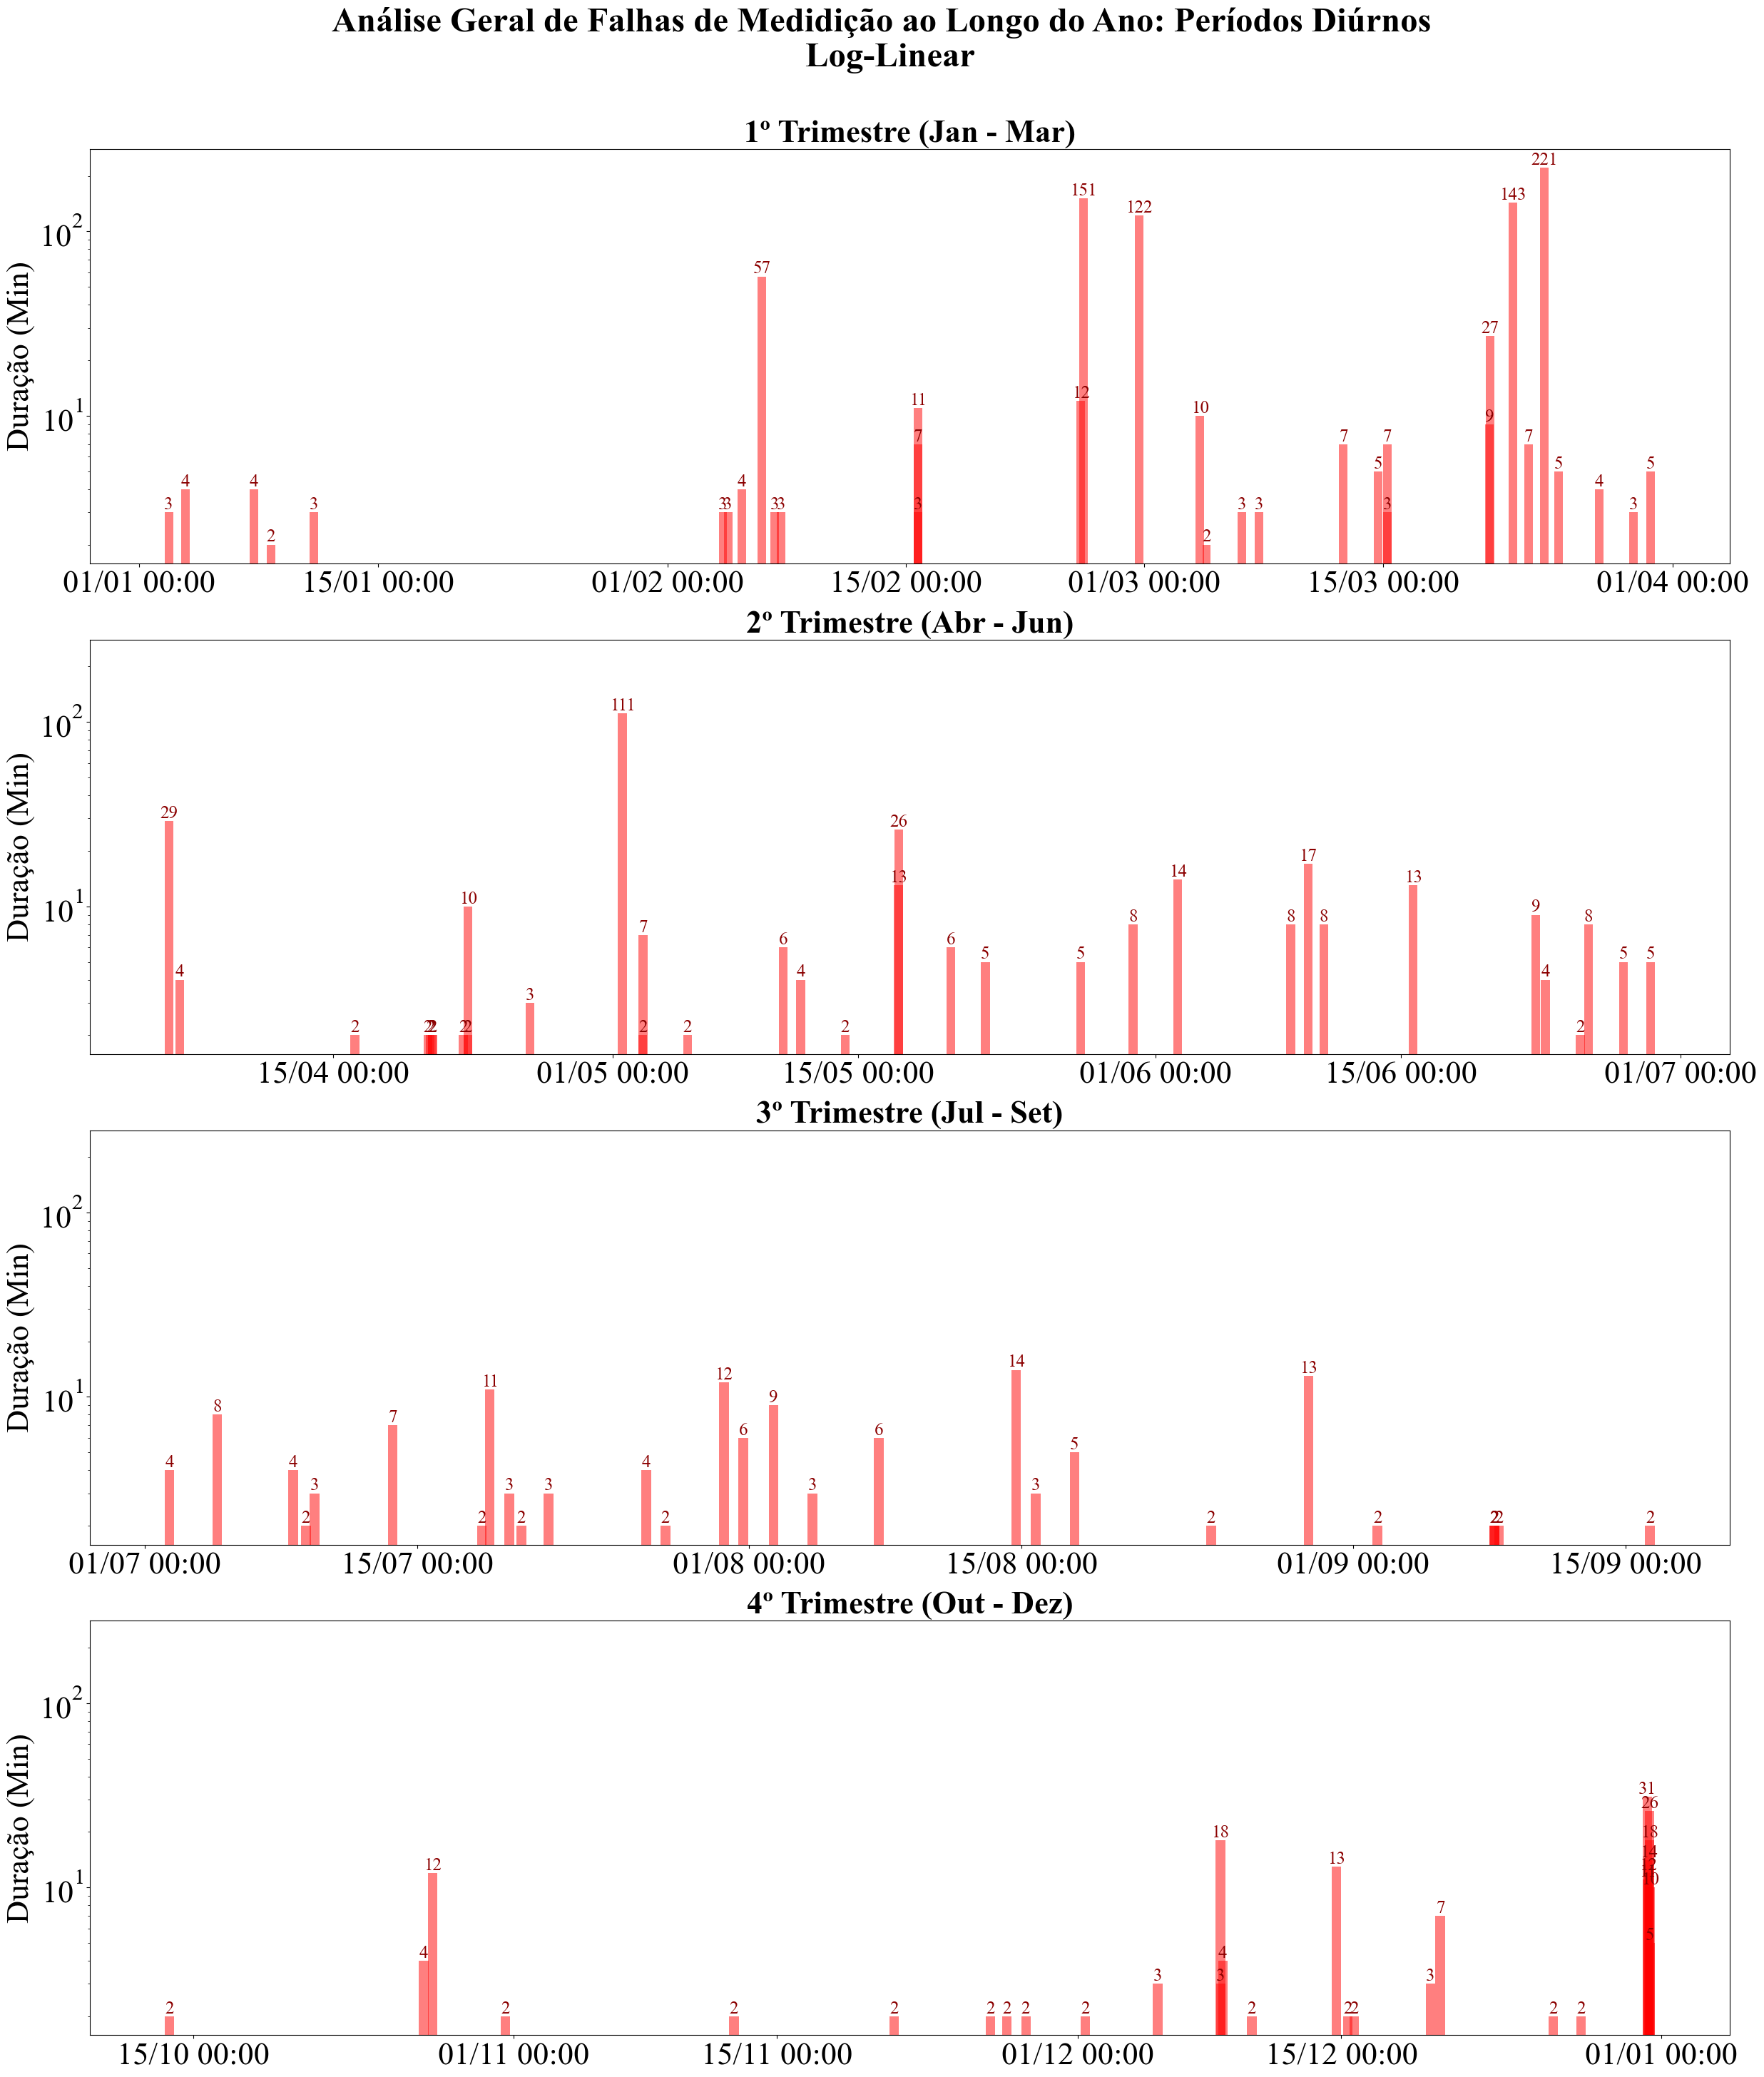

In [89]:
gaps_q1 = gaps_day[gaps_day.index.month <= 3]
gaps_q2 = gaps_day[(gaps_day.index.month > 3) & (gaps_day.index.month <= 6)]
gaps_q3 = gaps_day[(gaps_day.index.month > 6) & (gaps_day.index.month <= 9)]
gaps_q4 = gaps_day[gaps_day.index.month > 9]
fontsize_= 32
if len(gaps_day) > 0:
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 30), sharey=True)
    fig.suptitle('Análise Geral de Falhas de Medidição ao Longo do Ano: Períodos Diúrnos \n Log-Linear', fontsize=35, fontweight='bold', y=0.97)
    def plotar_periodo(ax, dados, titulo):
        if len(dados) == 0:
            ax.text(0.5, 0.5, "Sem falhas registradas neste trimestre", 
                    ha='center', va='center', transform=ax.transAxes, fontsize=fontsize_, color='gray')
            ax.set_title(titulo, fontsize=fontsize_, fontweight='bold')
            ax.grid(True, linestyle='--', alpha=0.3)
            return
        minutos = dados.dt.total_seconds() / 60
        ax.bar(dados.index, minutos, width=0.5, color='red', alpha=0.5)
        ax.set_yscale('log')
        ax.set_title(titulo, fontsize=fontsize_, fontweight='bold')
        ax.set_ylabel('Duração (Min)', fontsize=fontsize_)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
        #ax.grid(True, linestyle='--', alpha=0.5)
        for date, duration in zip(dados.index, minutos):
            ax.annotate(f'{int(duration)}', 
                        xy=(date, duration), 
                        xytext=(0, 3), textcoords='offset points', 
                        ha='center', fontsize=18, color='darkred')
    configuracoes = [
        (axes[0], gaps_q1, '1º Trimestre (Jan - Mar)'),
        (axes[1], gaps_q2, '2º Trimestre (Abr - Jun)'),
        (axes[2], gaps_q3, '3º Trimestre (Jul - Set)'),
        (axes[3], gaps_q4, '4º Trimestre (Out - Dez)')]
    for ax, dados, titulo in configuracoes:
        plotar_periodo(ax, dados, titulo)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=fontsize_)
        plt.setp(ax.yaxis.get_majorticklabels(), fontsize=fontsize_) 
    # O parametro rect=[0, 0, 1, 0.96] diz para o layout usar apenas os 96% de baixo da figura,
    # deixando os 4% do topo livres para o suptitle não ser atropelado.
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    #plt.savefig('./GRAFICOS/Analise Geral de Falhas de Medidição ao Longo do Ano Para Períodos Diúrnos.png', format='png', dpi=600, bbox_inches='tight')
    plt.savefig('./GRAFICOS/Analise Geral de Falhas de Medidição ao Longo do Ano Para Períodos Diúrnos.pdf', format='pdf', bbox_inches='tight')
    plt.show()
else:
    print("Nenhum gap encontrado.")

# Plot do Gráfico de Flutuação de Irradiancia

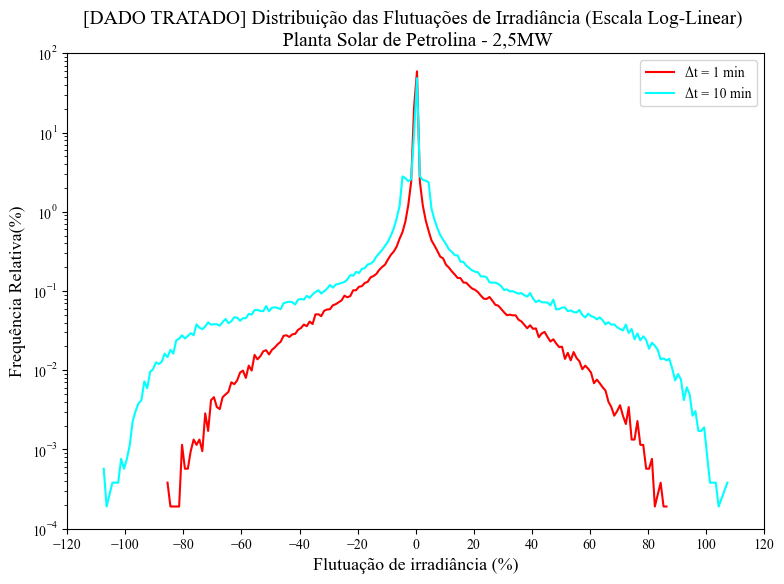

In [14]:
# CÁLCULO DAS FLUTUAÇÕES DE IRRADIANCIA
deltas = [1, 10] # Delta t = 1 min e Delta t = 10 min
cores = ['red', 'cyan'] # Cores iguais ao artigo para 60s e 600s
irradiacao_de_referencia = 1000
for delta_t, cor in zip(deltas, cores):
    # O método .diff do Pandas: .diff(periods=k) faz G(t) - G(t-k)
    # A fórmula do artigo: (Diferença / 1000) * 100
    fluctuation_G = (df_new['G'].diff(periods=delta_t) / irradiacao_de_referencia) * 100
    # Remover o NaN gerados pelo .diff
    fluctuation_G = fluctuation_G.dropna()
    # CRIAÇÃO DO HISTOGRAMA (Bins de 1%)
    # faixas de -120% a +120% com passo de 1%
    bins = np.arange(-120, 121, 1) 
    # np.histogram conta quantos eventos caem em cada faixa
    counts, bin_edges = np.histogram(fluctuation_G, bins=bins)
    # Calcular o centro de cada bin para plotar a linha
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    # NORMALIZAÇÃO (O Eixo Y)
    # Frequência Relativa (%) = (Contagem / Total) * 100
    rel_freq = (counts / len(fluctuation_G)) * 100
    # PLOTAGEM (Escala Log-Linear)
    # Filtra valores com frequencia 0 para não quebrar o log
    mask = rel_freq > 0
    plt.plot(bin_centers[mask], rel_freq[mask], 
             label=f'Δt = {delta_t} min', 
             color=cor, linewidth=1.5)
plt.yscale('log')
plt.xlabel('Flutuação de irradiância (%)', fontsize=13)
plt.ylabel('Frequência Relativa(%)', fontsize=13)
plt.title('[DADO TRATADO] Distribuição das Flutuações de Irradiância (Escala Log-Linear) \n Planta Solar de Petrolina - 2,5MW', fontsize=14)
#plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.ylim(10**-4, 100) # Ajuste similar ao artigo
plt.xlim(-120, 120)
plt.xticks([-120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120])
plt.tight_layout()
plt.savefig('./GRAFICOS/DADO_TRATADO_distribuicao_da_irradiancia.png', format='png', dpi=600, bbox_inches='tight')

# Plot do Gráfico de Futuação de Potencia

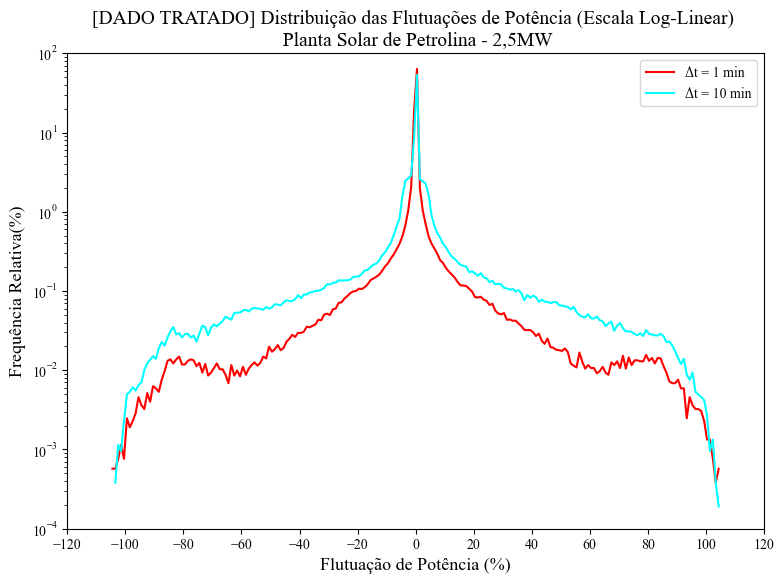

In [15]:
# CÁLCULO DAS FLUTUAÇÕES POTENCIA
deltas = [1, 10] # Delta t = 1 min e Delta t = 10 min
cores = ['red', 'cyan'] # Cores iguais ao artigo para 60s e 600s
potecia_de_referencia = 2500
for delta_t, cor in zip(deltas, cores):
    # O método .diff do Pandas: .diff(periods=k) faz G(t) - G(t-k)
    # A fórmula do artigo: (Diferença / 1000) * 100
    fluctuation_P = (df_new['P'].diff(periods=delta_t) / potecia_de_referencia) * 100
    # Remover o NaN gerados pelo .diff
    fluctuation_P = fluctuation_P.dropna()
    # 2. CRIAÇÃO DO HISTOGRAMA (Bins de 1%)    
    # faixas de -120% a +120% com passo de 1%
    bins = np.arange(-120, 121, 1) 
    # np.histogram conta quantos eventos caem em cada faixa
    counts, bin_edges = np.histogram(fluctuation_P, bins=bins)
    # Calcular o centro de cada bin para plotar a linha
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    # NORMALIZAÇÃO (O Eixo Y)
    # Frequência Relativa (%) = (Contagem / Total) * 100
    rel_freq = (counts / len(fluctuation_P)) * 100
    # PLOTAGEM (Escala Log-Linear)
    # Filtra valores com frequencia 0 para não quebrar o log
    mask = rel_freq > 0
    plt.plot(bin_centers[mask], rel_freq[mask], 
             label=f'Δt = {delta_t} min', 
             color=cor, linewidth=1.5)
plt.yscale('log')
plt.xlabel('Flutuação de Potência (%)', fontsize=13)
plt.ylabel('Frequência Relativa(%)', fontsize=13)
plt.title('[DADO TRATADO] Distribuição das Flutuações de Potência (Escala Log-Linear) \n Planta Solar de Petrolina - 2,5MW', fontsize=14)
#plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.ylim(10**-4, 100) # Ajuste similar ao artigo
plt.xlim(-120, 120)
plt.xticks([-120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120])
plt.tight_layout()
plt.savefig('./GRAFICOS/DADO_TRATADO_distribuicao_da_potencia.png', format='png', dpi=600, bbox_inches='tight')